In [7]:
import numpy as np
import matplotlib.pyplot as plt
from Bio import SeqIO
plt.style.use('dark_background')

### Functions

In [24]:
def nucl_lists():
    """
    Generate lists of possible nucleotides
    
    Outputs:
    di_list - list of possible dinuclotides
    tri_list - list of possible trinuclotides
    tetra_list - list of possible tetranuclotides
    """
    
    nucl = ["A","T","C","G"]
    di_list = [i+j for i in nucl for j in nucl]
    tri_list = [i+j for i in di_list for j in nucl]
    tetra_list = [i+j for i in tri_list for j in nucl]

    return (di_list, tri_list, tetra_list)
  
    
def rev_comp(string):
    """
    Return reverse complement of DNA strand
    
    Input - sequence
    
    Output - reverse complement
    """
    
    complementary = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'} 
    comp = ''
    for i in string:
        comp += complementary[i]

    return comp[::-1]

    
def count_occurrences(subsequence, sequence):
    """
    Count occurrences of substring in a string
    (including overlaping substrings)
    
    Inputs:
    sequence - sequence
    subsequence - subsequence to be found in sequence
    
    Output: number of occurrences of subsequence in sequence
    """
    number_of_occurrences = 0
    for i in range(len(sequence)):
        if sequence[i:i+len(subsequence)] == subsequence:
            number_of_occurrences += 1
            
    return number_of_occurrences


def get_frequencies(sequence):
    """
    Count occurrences of oligonuclotides in sequence
    
    Input - sequence
    
    Outputs:
    tetra_freq - array of tetranuclotides counts
    tri_freq - array of trinuclotides counts
    di_freq - array of dinuclotides counts
    """
    encoding = {'A':0, 'T':1, 'C':2, 'G':3}
    
    seq = np.zeros(4)
    tetra_freq = np.zeros(256)
    tri_freq = np.zeros(64)
    di_freq = np.zeros(16)
    
    n = 1
    for i in sequence:

        seq[0] = seq[1]
        seq[1] = seq[2]
        seq[2] = seq[3]
        seq = seq*4
        seq[3] = encoding[i]
        
        if n > 1:
            di_freq[int(seq[2:5].sum())] += 1
            
        if n > 2:
            tri_freq[int(seq[1:5].sum())] += 1
            
        if n > 3:
            tetra_freq[int(seq.sum())] += 1
        n +=1
    
    return(tetra_freq, tri_freq, di_freq)


def rev_comp_freq(oligo_list, oligo_freq):
    """
    Calculate frequencies of oligonuclotides from the complementary strand
    
    Inputs:
    oligo_list - list of oligonuclotides
    oligo_freq - list of oligonuclotides counts
    
    Output - updated frequencies
    """
    
    r_dir = {oligo_list[i]:oligo_freq[i] for i in range(len(oligo_list))}
    
    for i in range(len(oligo_list)):
        oligo_freq[i] += r_dir[rev_comp(oligo_list[i])]
    
    return oligo_freq


def exp_tnf(tetra_list, tri_nucl, di_nucl):
    """
    Calculate expected tetranucleotide frequency
    
    Inputs:
    tetra_list - list of tetranuclotides
    tri_nucl - dictionary of trinuclotides frequency
    di_nucl - dictionary of dinuclotides frequency
    
    Output: expected tetranuclotide frequency
    """
    
    expected_tnf = np.zeros(len(tetra_list))
    for i in range(len(tetra_list)):
        tn = tetra_list[i]
        expected_tnf[i] = (tri_nucl[tn[0:3]]*tri_nucl[tn[1:4]])/di_nucl[tn[1:3]]
            
    return expected_tnf


def app_variance(expected_tnf, tetra_list, tri_nucl, di_nucl):
    """
    Approximated variance of tetranuclotide frequency
    
    Inputs:
    expected_tnf - expected tetranuclotide frequency
    tetra_list - list of tetranuclotides
    tri_nucl - dictionary of trinuclotides frequency
    di_nucl - dictionary of dinuclotides frequency
    
    Output - approximated variance of tetranuclotide frequency
    """
    
    app_var = np.zeros(len(tetra_list))
    for i in range(len(tetra_list)):
        tn = tetra_list[i]
        n23 = di_nucl[tn[1:3]]
        n123 = tri_nucl[tn[0:3]]
        n234 = tri_nucl[tn[1:4]]
        app_var[i] = expected_tnf[i] * (((n23-n123)*(n23-n234))/(n23*n23))
            
    return app_var


def tnf_z_score(tetra_freq, expected_tnf, app_var):
    """
    Calculate tetranuclotide z-score
    
    Inputs:
    tetra_freq - observed tetranuclotide frequency
    expected_tnf - expected tetranuclotide frequency
    app_var - approximated variance of tetranuclotide frequency
    
    Output - tetranuclotide z-score
    """
    
    z_scores = (tetra_freq-expected_tnf)/np.sqrt(app_var)
    return z_scores


def get_z_scores(sequence, di_list, tri_list, tetra_list):
    """
    Calculate z-scores from sequence
    
    Inputs:
    sequence - DNA sequence
    di_list - list of possible dinuclotides
    tri_list - list of possible trinuclotides
    tetra_list - list of possible tetranuclotides
    
    Output - np array of z-scores
    """
    
    tetra_freq, tri_freq, di_freq = get_frequencies(sequence)
    tetra_freq = rev_comp_freq(tetra_list, tetra_freq)
        
    di_nucl = {di_list[i]:di_freq[i] for i in range(len(di_list))}
    tri_nucl = {tri_list[i]:tri_freq[i] for i in range(len(tri_list))}
    
    expected_tnf = exp_tnf(tetra_list, tri_nucl, di_nucl)
    app_var = app_variance(expected_tnf, tetra_list, tri_nucl, di_nucl)
    z_scores = tnf_z_score(tetra_freq, expected_tnf, app_var)
    
    return z_scores


def inter_correlations(all_z_scores):
    """
    Calcualte Person's correlation coefficient between fragment and median
    
    Input - np array of z-scores for all fragments
    
    Output - np array of correlation coeeficients
    """
    
    median_z = np.median(all_z_scores, axis=0)

    correlations = np.zeros(len(all_z_scores))
    for i in range(len(all_z_scores)):
        correlations[i] = np.corrcoef(all_z_scores[i], median_z)[1,0]
        
    return correlations

### Tetranucleotide Z-score

In [9]:
contigs = SeqIO.parse("./test.fasta", 'fasta')
di_list, tri_list, tetra_list = nucl_lists()

contigs_z_scores = []
for record in contigs:  
    z_scores = get_z_scores(record.seq, di_list, tri_list, tetra_list)
    contigs_z_scores.append(z_scores)
    
contigs_z_scores = np.array(contigs_z_scores)

contig_corr = inter_correlations(contigs_z_scores)



/home/kuba/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:110: RuntimeWarning: invalid value encountered in double_scalars
/home/kuba/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in double_scalars
/home/kuba/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:151: RuntimeWarning: invalid value encountered in true_divide
/home/kuba/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median for 256 results
  r = func(a, **kwargs)


In [23]:
contigs = SeqIO.parse("./test.fasta", 'fasta')
di_list, tri_list, tetra_list = nucl_lists()

for record in contigs:
    tetra_freq, tri_freq, di_freq = get_frequencies(record.seq)
    tetra_freq = rev_comp_freq(tetra_list, tetra_freq)

    
    print(tetra_freq)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 

NameError: name 'median_z' is not defined

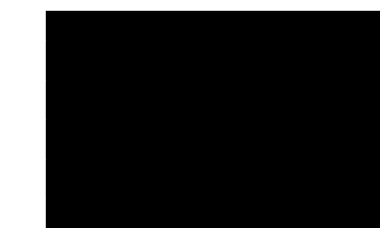

In [11]:
#plt.plot(np.amax(all_z_scores, axis=0), alpha=0.4)
#plt.plot(np.amin(all_z_scores, axis=0), alpha=0.4)
plt.fill_between(range(256), np.amax(contigs_z_scores, axis=0), np.amin(contigs_z_scores, axis=0),
                 alpha=0.4)
plt.plot(median_z)
plt.show()